# Rainfall time-series dataset released by WFP 

The data regarding the rainfalls are provided to the wfp: https://dataviz.vam.wfp.org/seasonal_explorer/rainfall_vegetation/visualizations#

We have collected only the data of the provinces that appear in the *Food Consumption Score* (or *Reduced Coping Strategy Index*) dataset.

In [1]:
import pandas as pd
import ntpath
import glob

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from map_plot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

# YEM, NGA, SYR, BFA

The data of four countries are provided: *Yemen* (YEM), *Nigeria* (NGA), *Syria* (SYR) and *Burkina Faso* (BFA).

In [4]:
# Read the data released by wfp regarding the rainfall in the adminstratas of the selected countries.
path = "./wfp_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_subfolders = glob.glob(path + country + "/Rainfall/*")
    for subfolder in all_subfolders:
        adminstrata = ntpath.basename(subfolder).split(".")[0]
        # All the files of the years.
        all_files = glob.glob(subfolder + "/*.csv")
        for filename in all_files:
            df = pd.read_csv(filename)
            df["AdminStrata"] = adminstrata
            df["Country"] = country
            dfs.append(df)

In [5]:
print("The data released by wfp:")
df = pd.concat(dfs, axis = 0, ignore_index = True)
df.head()

The data released by wfp:


,Year,Month,Dekad,1 Month Anomaly (%),3 Months Anomaly (%),Value,Average,AdminStrata,Country
0,2016,1,1,100.0,189.592966,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
1,2016,1,2,100.0,124.756206,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
2,2016,1,3,100.0,103.215912,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
3,2016,2,1,100.0,100.129909,0.00,0.0,Boucle-Du-Mouhoun,Burkina Faso
4,2016,2,2,100.1,100.159968,0.01,0.0,Boucle-Du-Mouhoun,Burkina Faso


In [6]:
# Delete the duplicate rows of the dataframe (some date have duplicate information due to loading data from different files).
df.drop_duplicates(inplace = True)

### Brief items description

- *Year*: reference year of the data collection.
- *Month*: reference month of the data collection.
- *Dekad*: reference month dekad of the data collection: these correspond to the calendar dates 1-10, 11-20, and 21-end of each month.
- *1 Month Anomaly (%)*: the value of 1 month rainfall anomaly in the reference period.
- *3 Months Anomaly (%)*: the value of 3 month rainfall anomaly in the reference period.
- *Value*: rainfall amount in the reference period.
- *Average*: long-term rainfall average for the same period.
- *AdminStrata*: the adminstrata information of the reference country.
- *Country*: the country information.

### Country item

In [7]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Nigeria, Syria, Yemen


### AdminStrata item

In [8]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen**: the administrative division of Yemen is divided into two main divisions (governorates and districts). There are 22 governorates, including the capital Sana'a (Amanat Al Asimah) and Socotra Archipelago. The rainfall dataframe has the values of all the governorates.

In [9]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", 'Al Hudaydah',
       'Al Jawf', 'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran',
       'Dhamar', 'Hadramaut', 'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah',
       "Sa'ada", "Sana'a", 'Shabwah', 'Socotra', 'Taizz'], dtype=object)

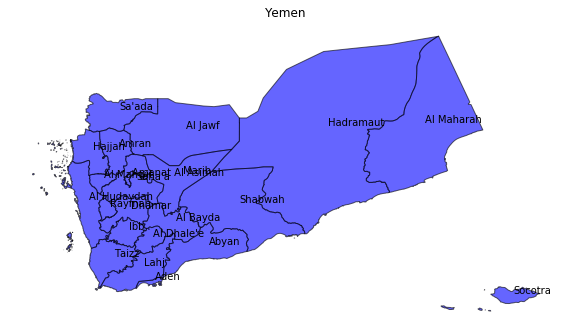

In [10]:
draw_adminstratas("Yemen", AdminStratas["Yemen"], "../Shape Files/shapefiles/Yemen/administrative level 1", figsize = (10, 7), annotation = True)

- **Nigeria**: Nigeria is divided into 36 states. It also includes *The Federal Capital Territory* that is not a state and it is under the direct control of the federal government. The AdminStrata items of the rainfall dataframe cover 3 states: Adamawa, Borno and Yobe.

In [11]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

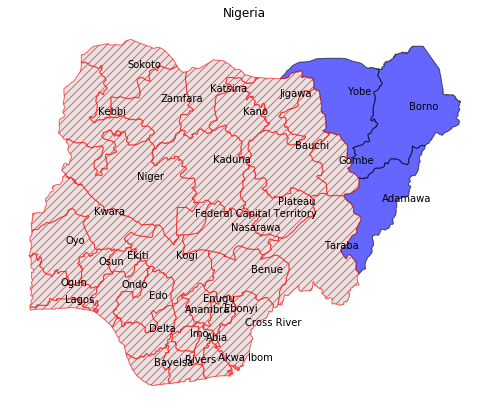

In [12]:
draw_adminstratas("Nigeria", AdminStratas["Nigeria"], "../Shape Files/shapefiles/Nigeria/administrative level 1", figsize = (10, 7), annotation = True)

- **Syria**: the governatores of the Syria country are 14. The rainfall dataframe has the values of 13 governorates (Idleb governatore not included).

In [13]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Al-Hasakeh', 'Aleppo', 'Ar-Raqqa', 'As-Sweida', 'Damascus',
       "Dar'a", 'Deir-ez-Zor', 'Hama', 'Homs', 'Lattakia', 'Quneitra',
       'Rural Damascus', 'Tartous'], dtype=object)

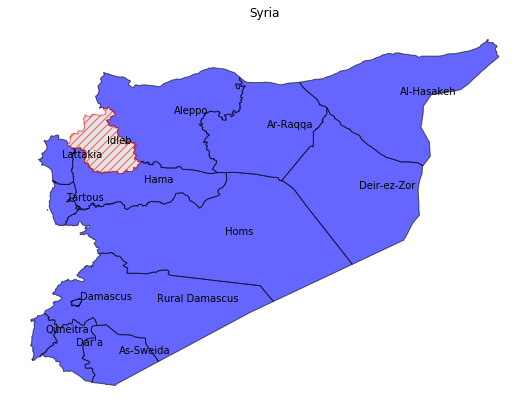

In [14]:
draw_adminstratas("Syria", AdminStratas["Syria"], "../Shape Files/shapefiles/Syria/administrative level 1", figsize = (10, 7), annotation = True)

- **Burkina Faso**: Burkina Faso is divided into 13 administrative regions. The rainfall dataframe has the values of all 13 regions.

In [15]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

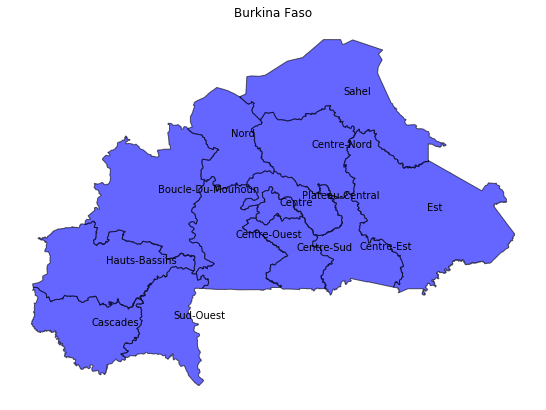

In [16]:
draw_adminstratas("Burkina Faso", AdminStratas["Burkina Faso"], "../Shape Files/shapefiles/Burkina Faso/administrative level 1", figsize = (10, 7), annotation = True)

In [17]:
# Convert the dekad to proper pandas datetime format.
# These correspond to the calendar dates 1-10, 11-20, and 21-end of each month.
def dekad_to_day(row):
    date = pd.to_datetime(str(row["Year"]) + "-" + str(row["Month"]) + "-01")
    end_month = date.days_in_month
    dekad = row.Dekad   
    if dekad == 1:
        return 10
    if dekad == 2:
        return 20
    if dekad == 3:
        return end_month
    
df["Day"] = df.apply(dekad_to_day, axis = 1)
df.drop(columns = "Dekad", inplace = True)
data = pd.to_datetime(df[["Year", "Month", "Day"]])
df.insert(1, "Datetime", data)
df.drop(["Year", "Month", "Day"], axis = 1, inplace = True)
df.sort_values("Datetime", ascending = True, inplace = True) 
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,1 Month Anomaly (%),3 Months Anomaly (%),Value,Average
0,Burkina Faso,Boucle-Du-Mouhoun,2016-01-10,100.0,189.592966,0.0,0.0
1,Burkina Faso,Boucle-Du-Mouhoun,2016-01-11,NaN,NaN,NaN,NaN
2,Burkina Faso,Boucle-Du-Mouhoun,2016-01-12,NaN,NaN,NaN,NaN
3,Burkina Faso,Boucle-Du-Mouhoun,2016-01-13,NaN,NaN,NaN,NaN
4,Burkina Faso,Boucle-Du-Mouhoun,2016-01-14,NaN,NaN,NaN,NaN


In [18]:
# Rename of some columns.
df.rename(columns = {"3 Months Anomaly (%)": "3 Months Anomaly (%) Rainfall", "Value": "Rainfall (mm)", "1 Month Anomaly (%)": "1 Month Anomaly (%) Rainfall"}, inplace = True)
# Delete average column.
df.drop(columns = "Average", inplace = True)

In [19]:
# Create multi-index column dataframe.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"]).reorder_levels([1, 2, 0], axis = 1).sort_index(1)
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    189.592966   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10            0.0                    109.51391   
2016-01-11            NaN                          NaN   
2016-01-12            NaN                          NaN   
2016-01-13            NaN                          NaN   
2016-01-14            NaN                          NaN   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                     174.733681         0.725   
2016-01-11                            NaN           NaN   
2016-01-12                            NaN           NaN   
2016-01-13                            NaN           NaN   
2016-01-14                            NaN           NaN   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    155.165163   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                   101.179528  ...         1.236   
2016-01-11            NaN                          NaN  ...           NaN   
2016-01-12            NaN                          NaN  ...           NaN   
2016-01-13            NaN                          NaN  ...           NaN   
2016-01-14            NaN                          NaN  ...           NaN   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                    104.417434                    119.919683   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [20]:
# Now check if it is necessary interpolate the nan values of the datetime dekadly.
df = df.loc[(df.index.day == 10) | (df.index.day == 20) | (df.index.is_month_end)]
# Keep dataframe from first to end valid index based on the measured rainfall.
first_idx = df.first_valid_index()
last_idx = df.last_valid_index()
df = df.loc[first_idx:last_idx]
# Check if the dataframe contains NaN values in correspondence of the dekades.
print("Check if the dataframe contains NaN values:")
df.isnull().sum()

Check if the dataframe contains NaN values:


Country       AdminStrata        Indicator                    
Burkina Faso  Boucle-Du-Mouhoun  1 Month Anomaly (%) Rainfall     0
                                 3 Months Anomaly (%) Rainfall    0
                                 Rainfall (mm)                    0
              Cascades           1 Month Anomaly (%) Rainfall     0
                                 3 Months Anomaly (%) Rainfall    0
                                                                 ..
Yemen         Socotra            3 Months Anomaly (%) Rainfall    0
                                 Rainfall (mm)                    0
              Taizz              1 Month Anomaly (%) Rainfall     0
                                 3 Months Anomaly (%) Rainfall    0
                                 Rainfall (mm)                    0
Length: 153, dtype: int64

In [21]:
df.isnull().sum().sum()

0

In [22]:
# Resample data to daily level (as before).
df = df.resample("D").mean()
df.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    189.592966   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10            0.0                    109.51391   
2016-01-11            NaN                          NaN   
2016-01-12            NaN                          NaN   
2016-01-13            NaN                          NaN   
2016-01-14            NaN                          NaN   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                     174.733681         0.725   
2016-01-11                            NaN           NaN   
2016-01-12                            NaN           NaN   
2016-01-13                            NaN           NaN   
2016-01-14                            NaN           NaN   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                         100.0                    155.165163   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                   101.179528  ...         1.236   
2016-01-11            NaN                          NaN  ...           NaN   
2016-01-12            NaN                          NaN  ...           NaN   
2016-01-13            NaN                          NaN  ...           NaN   
2016-01-14            NaN                          NaN  ...           NaN   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                    104.417434                    119.919683   
2016-01-11                           NaN                           NaN   
2016-01-12                           NaN                           NaN   
2016-01-13                           NaN                           NaN   
2016-01-14                           NaN                           NaN   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [23]:
# Plot time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Rainfall", 
                             first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

## Interpolation of the time-series at day granularity

I get the dataframe with timestep of the day filling nan values (because I have information only for the dekades of the month) with previous value dekad. More precisely, being the values of the dekaed the tototal amount of rainfall happened in that interval I divide for the days of the range of the dekad. 

In [24]:
# I get the dataframe with time step of the day filling nan values with previous value dekad.
df_fit = df.fillna(method = "bfill")
freq = "D"
df_fit.index.freq = freq
# Furthermore, being the values of the dekaed the tot rainfall happened in that interval I divide for the days of the range of the dekad.
def dekad_day_norm(row):
    if row.name.day >= 1 or row.name.day <= 10:
        return row/10
    if row.name.day >= 11 or row.name.day <= 20:
        return row/10
    if row.name.day >= 21:
        return row/row.name.days_in_month - 20

df_fit = df_fit.apply(dekad_day_norm, axis = 1)
df_fit.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                          10.0                     18.959297   
2016-01-11                          10.0                     12.475621   
2016-01-12                          10.0                     12.475621   
2016-01-13                          10.0                     12.475621   
2016-01-14                          10.0                     12.475621   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10            0.0                    10.951391   
2016-01-11            0.0                    10.833582   
2016-01-12            0.0                    10.833582   
2016-01-13            0.0                    10.833582   
2016-01-14            0.0                    10.833582   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-01-10                      17.473368        0.0725   
2016-01-11                      14.463080        0.0055   
2016-01-12                      14.463080        0.0055   
2016-01-13                      14.463080        0.0055   
2016-01-14                      14.463080        0.0055   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                          10.0                     15.516516   
2016-01-11                          10.0                     11.961419   
2016-01-12                          10.0                     11.961419   
2016-01-13                          10.0                     11.961419   
2016-01-14                          10.0                     11.961419   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-01-10            0.0                    10.117953  ...        0.1236   
2016-01-11            0.0                    10.104979  ...        0.0831   
2016-01-12            0.0                    10.104979  ...        0.0831   
2016-01-13            0.0                    10.104979  ...        0.0831   
2016-01-14            0.0                    10.104979  ...        0.0831   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-01-10                     10.441743                     11.991968   
2016-01-11                     10.513699                     11.913338   
2016-01-12                     10.513699                     11.913338   
2016-01-13                     10.513699                     11.913338   
2016-01-14                     10.513699                     11.913338   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-01-10        

In [25]:
# Plot time-series.
TsIP(df_fit).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Rainfall", 
                                 first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [26]:
# Now save the time-series of each country keeping as indeces for each time-series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [27]:
df_fit.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rainfall"));

Now, I adjust the current data according to the reference period of the data collection of the fcs indicator. The fcs survey uses a sliding window of 30 days past to determine the current value. 

In [28]:
SvyWindow = 30

In [29]:
df_fit_SvyWindow = df_fit.rolling(SvyWindow + 1).sum().dropna()
df_fit_SvyWindow.head()

Country                     Burkina Faso                                \
AdminStrata            Boucle-Du-Mouhoun                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-02-09                        310.00                    347.369924   
2016-02-10                        310.00                    338.423618   
2016-02-11                        310.01                    335.963994   
2016-02-12                        310.02                    333.504371   
2016-02-13                        310.03                    331.044747   

Country                                                 \
AdminStrata                                   Cascades   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-02-09          0.000                   333.293360   
2016-02-10          0.000                   332.797271   
2016-02-11          0.001                   332.324264   
2016-02-12          0.002                   331.851257   
2016-02-13          0.003                   331.378249   

Country                                                  \
AdminStrata                                               
Indicator   3 Months Anomaly (%) Rainfall Rainfall (mm)   
Datetime                                                  
2016-02-09                     379.360422        0.7226   
2016-02-10                     372.656742        0.6952   
2016-02-11                     369.954504        0.7595   
2016-02-12                     367.252267        0.8238   
2016-02-13                     364.550030        0.8881   

Country                                                                 \
AdminStrata                       Centre                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-02-09                         310.0                    335.238943   
2016-02-10                         310.0                    329.722427   
2016-02-11                         310.0                    327.761008   
2016-02-12                         310.0                    325.799589   
2016-02-13                         310.0                    323.838170   

Country                                                 ...         Yemen  \
AdminStrata                                 Centre-Est  ...        Sana'a   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall  ... Rainfall (mm)   
Datetime                                                ...                 
2016-02-09            0.0                   311.167743  ...        3.8669   
2016-02-10            0.0                   311.049790  ...        3.9179   
2016-02-11            0.0                   310.954784  ...        4.0209   
2016-02-12            0.0                   310.859778  ...        4.1239   
2016-02-13            0.0                   310.764772  ...        4.2269   

Country                                                                 \
AdminStrata                      Shabwah                                 
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2016-02-09                    325.716797                    359.868720   
2016-02-10                    325.815219                    358.816450   
2016-02-11                    325.918795                    357.824092   
2016-02-12                    326.022371                    356.831734   
2016-02-13                    326.125947                    355.839375   

Country                                                 \
AdminStrata                                    Socotra   
Indicator   Rainfall (mm) 1 Month Anomaly (%) Rainfall   
Datetime                                                 
2016-02-09        

In [30]:
# Plot time-series.
TsIP(df_fit_SvyWindow).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Rainfall", 
                                           first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [31]:
df_fit_SvyWindow.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rainfall_SvyWindow"));